<a href="https://colab.research.google.com/github/hmezer/eam-double-response/blob/main/files/sbi_double_response.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**The following are reference works using BayesFlow**

https://github.com/bayesflow-org/bayesflow-workshop-quant-psych/blob/main/exercises/bayesflow-diffusion.ipynb

The presentation slides [are here.](https://www.canva.com/design/DAGsB3IT0QM/Q9hxlQP4OHgTY0Rn3MH15g/edit?utm_content=DAGsB3IT0QM&utm_campaign=designshare&utm_medium=link2&utm_source=sharebutton)

[*Double responding: A new constraint for models of speeded decision making*](https://www.sciencedirect.com/science/article/pii/S0010028520300219?via%3Dihub)

The data from the article [is here.](https://www.gillesdutilh.com/pages/materials_practice1.htm)


[**MODELS IN CODE**](https://osf.io/7jmb2/files/osfstorage).


[Bu](https://royalsocietypublishing.org/doi/epdf/10.1098/rspb.2016.0291?src=getftr&utm_source=sciencedirect_contenthosting&getft_integrator=sciencedirect_contenthosting) ne amina koyim?

***

## Key Findings

* The study shows that double responding creates several interesting benchmarks that can help distinguish between the predictions of different EAMs, even in standard experimental paradigms.

* When EAMs are constrained to account for both choice response time distributions and double responding behavior simultaneously, their predictions become more distinct.

* The findings suggest that models incorporating lateral inhibition (like the Leaky Competing Accumulator, or LCA, which was also present in your initial table) are generally better at making accurate predictions for this combined data.

* In contrast, models containing feed-forward inhibition (such as the Diffusion Model) performed poorly when extended to account for double responding, suggesting they might be less capable of accurately predicting these specific behavioral patterns.
> Why do some of the models work poorly and others work better introducing the constraints?

In [ ]:
!pip install bayesflow tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 79.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.9/319.9 kB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 101.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 115.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 123.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 6.2 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 6.31.1
    Uninstalling protobuf-6.31.1:
      Successfully uninstalled protobuf-6.31.1


In [ ]:
import bayesflow as bf
import numpy as np
import pandas as pd

In [ ]:
def lca_trial_extended(
    v_0,     # Drift rate for accumulator 0 (single float)
    v_1,     # Drift rate for accumulator 1 (single float)
    a,       # Decision threshold (single float)
    ndt,     # Non-decision time (single float)
    la,      # Leakage rate (single float)
    ka,      # Lateral inhibition rate (single float)
    s=1.0,   # Diffusion noise scale (single float), typically fixed or inferred
    dt=0.001,# Time step size (in seconds, float)
    max_sim_time=5.0, # Maximum total simulation time (in seconds, float)
    double_response_window=0.25 # Time window for detecting double responses (in seconds, float)
):
    """
    Simulates a single trial of a Leaky Competing Accumulator (LCA) model,
    extended to account for double responses, for exactly TWO alternatives.

    Instead of one accumulator moving between two boundaries, it uses two
    accumulators, each representing a choice option, competing with each other
    through inhibition and decaying via leakage, racing to hit a common threshold.

    Parameters:
    -----------
    v_0 : float
        Drift rate for decision alternative 0.
    v_1 : float
        Drift rate for decision alternative 1.
    a : float
        Decision threshold. Must be positive.
        (Analogous to DDM's 'a').
    ndt : float
        Non-decision time (in seconds). Must be non-negative.
        (Analogous to DDM's 'ter').
    la : float
        Leakage rate. Evidence decays towards zero. Must be non-negative. (NEW LCA parameter)
    ka : float
        Lateral inhibition rate. Accumulators inhibit each other. Must be non-negative. (NEW LCA parameter)
    s : float, optional
        Scale of the diffusion noise for each accumulator. Default is 1.0.
        (Analogous to DDM's 's').
    dt : float, optional
        Time step (in seconds) for the discrete simulation. Default is 0.001 (1 ms).
    max_sim_time : float, optional
        Maximum total simulation time (in seconds) to prevent infinite loops. Default is 5.0s.
    double_response_window : float, optional
        Time window (in seconds) after the initial response during which a second
        response is considered a 'double response'. Default is 0.25s (250ms).

    Returns:
    --------
    tuple: (initial_rt, initial_choice, has_double_response, double_rt_relative, double_choice)
        initial_rt : float
            The simulated initial response time (RT) for the trial (in seconds).
            Returns np.nan if max_sim_time is reached without an initial decision.
        initial_choice : int
            The index of the initially chosen alternative (0 or 1).
            Returns -1 if max_sim_time is reached without an initial decision.
        has_double_response : int
            1 if a double response occurred, 0 otherwise.
        double_rt_relative : float
            The time from the initial response to the double response (in seconds).
            np.nan if no double response.
        double_choice : int
            The index of the double response alternative (0 or 1).
            -1 if no double response.
    """
    num_alternatives = 2 # Fixed to 2
    x = np.zeros(num_alternatives) # Accumulator evidence for each alternative
    v = np.array([v_0, v_1]) # Create array from individual drift rates
    noise_std = s * np.sqrt(dt)    # Correct scaling for Wiener process noise

    # Input validation (similar to your DDM script, but adapted for LCA params)
    if a <= 0 or ndt < 0 or s <= 0 or dt <= 0:
        # Return NaN for RT and -1 for choices if parameters are invalid
        return np.nan, -1, 0, np.nan, -1
    if la < 0 or ka < 0: # Leakage and inhibition rates must be non-negative
        return np.nan, -1, 0, np.nan, -1

    num_iter = 0
    max_iter = int(max_sim_time / dt)

    initial_rt_acc = np.nan # Accumulation time for initial response
    initial_choice = -1

    # --- Phase 1: Accumulation for Initial Response ---
    # Continue as long as no accumulator has reached the threshold and max_time is not exceeded
    while np.all(x < a) and num_iter < max_iter:
        noise = np.random.randn(num_alternatives) * noise_std # Independent noise for each accumulator
        sum_x_others = np.sum(x) # Sum of all accumulators for inhibition calculation

        for i in range(num_alternatives):
            # Calculate the inhibition term from other accumulators
            # In the Evans paper, it's beta * sum_of_others_evidence
            inhibition_term = ka * (sum_x_others - x[i])

            # Calculate the change in evidence (dx_i) for the current accumulator
            # dx_i = (drift - leakage * current_evidence - inhibition_from_others) * dt + noise
            dx_i = (v[i] - la * x[i] - inhibition_term) * dt + noise[i]

            # Update the accumulator's evidence
            x[i] += dx_i

            # Evidence typically cannot drop below zero in LCA (truncated accumulation)
            x[i] = max(0.0, x[i])

        num_iter += 1

    # Check if an initial decision was made
    if num_iter >= max_iter:
        # No initial decision made within max_sim_time
        return {
            "init_rt": np.nan,
            "init_resp": -1,
            "dr_if": 0,
            "dr_rt": np.nan,
            "dr_resp": -1
        } # RT=NaN, no decision, no double response

    # Initial decision made: find which accumulator crossed threshold first
    # np.where returns a tuple of arrays, [0][0] gets the index of the first crossing accumulator
    initial_choice = np.where(x >= a)[0][0]
    initial_rt_acc = num_iter * dt # Accumulation time for the first response

    # --- Phase 2: Continued Accumulation for Double Response ---
    # The simulation continues from the state immediately after the initial response

    has_double_response = 0
    double_rt_relative = np.nan
    double_choice = -1

    # Calculate the absolute time when the double response window ends
    double_response_end_time_abs = initial_rt_acc + double_response_window

    # Continue simulation within the double response window or until max_sim_time
    while num_iter * dt < double_response_end_time_abs and num_iter < max_iter:
        noise = np.random.randn(num_alternatives) * noise_std
        sum_x_others = np.sum(x)

        for i in range(num_alternatives):
            inhibition_term = ka * (sum_x_others - x[i])
            dx_i = (v[i] - la * x[i] - inhibition_term) * dt + noise[i]
            x[i] += dx_i
            x[i] = max(0.0, x[i])

            # Check if any *other* alternative crosses threshold after the initial choice
            if i != initial_choice and x[i] >= a:
                has_double_response = 1
                double_rt_relative = (num_iter * dt) - initial_rt_acc # Time from first response to second
                double_choice = i
                break # A double response occurred, exit inner loop

        if has_double_response == 1:
            break # A double response occurred, exit outer loop

        num_iter += 1 # Increment overall simulation time

    # Final initial RT (includes non-decision time)
    final_initial_rt = initial_rt_acc + ndt

    d = {
        "init_rt": final_initial_rt,
        "init_resp": initial_choice,
        "dr_if": has_double_response,
        "dr_rt": double_rt_relative,
        "dr_resp": double_choice
    }

    return d

In [ ]:
def sample_lca_prior():
    """
    Generates a single random draw from the joint prior distribution for LCA parameters.

    Returns:
    --------
    dict
        A dictionary containing a single sample for each LCA parameter.
    """
    # Drift rates (v_0, v_1): Normal(loc=0.0, scale=1.5)
    v_0 = np.random.normal(loc=0.0, scale=1.5)
    v_1 = np.random.normal(loc=0.0, scale=1.5)

    # Threshold (a): Uniform(low=0.5, high=2.5)
    a = np.random.uniform(low=0.5, high=2.5)

    # Non-decision time (ndt): Uniform(low=0.1, high=0.4)
    ndt = np.random.uniform(low=0.1, high=0.4)

    # Leakage rate (la): Uniform(low=0.0, high=0.5)
    la = np.random.uniform(low=0.0, high=0.5)

    # Lateral inhibition rate (ka): Uniform(low=0.0, high=0.5)
    ka = np.random.uniform(low=0.0, high=0.5)

    # Diffusion noise scale (s): Uniform(low=0.5, high=1.5)
    s = np.random.uniform(low=0.5, high=1.5)

    return {
        "v_0": v_0,
        "v_1": v_1,
        "a": a,
        "ndt": ndt,
        "la": la,
        "ka": ka,
        "s": s
    }


In [ ]:
simtor = bf.make_simulator([sample_lca_prior, lca_trial_extended])

In [ ]:
samples = simtor.sample(100)

/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:1615: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  func(x=x, y=y, **kwargs)


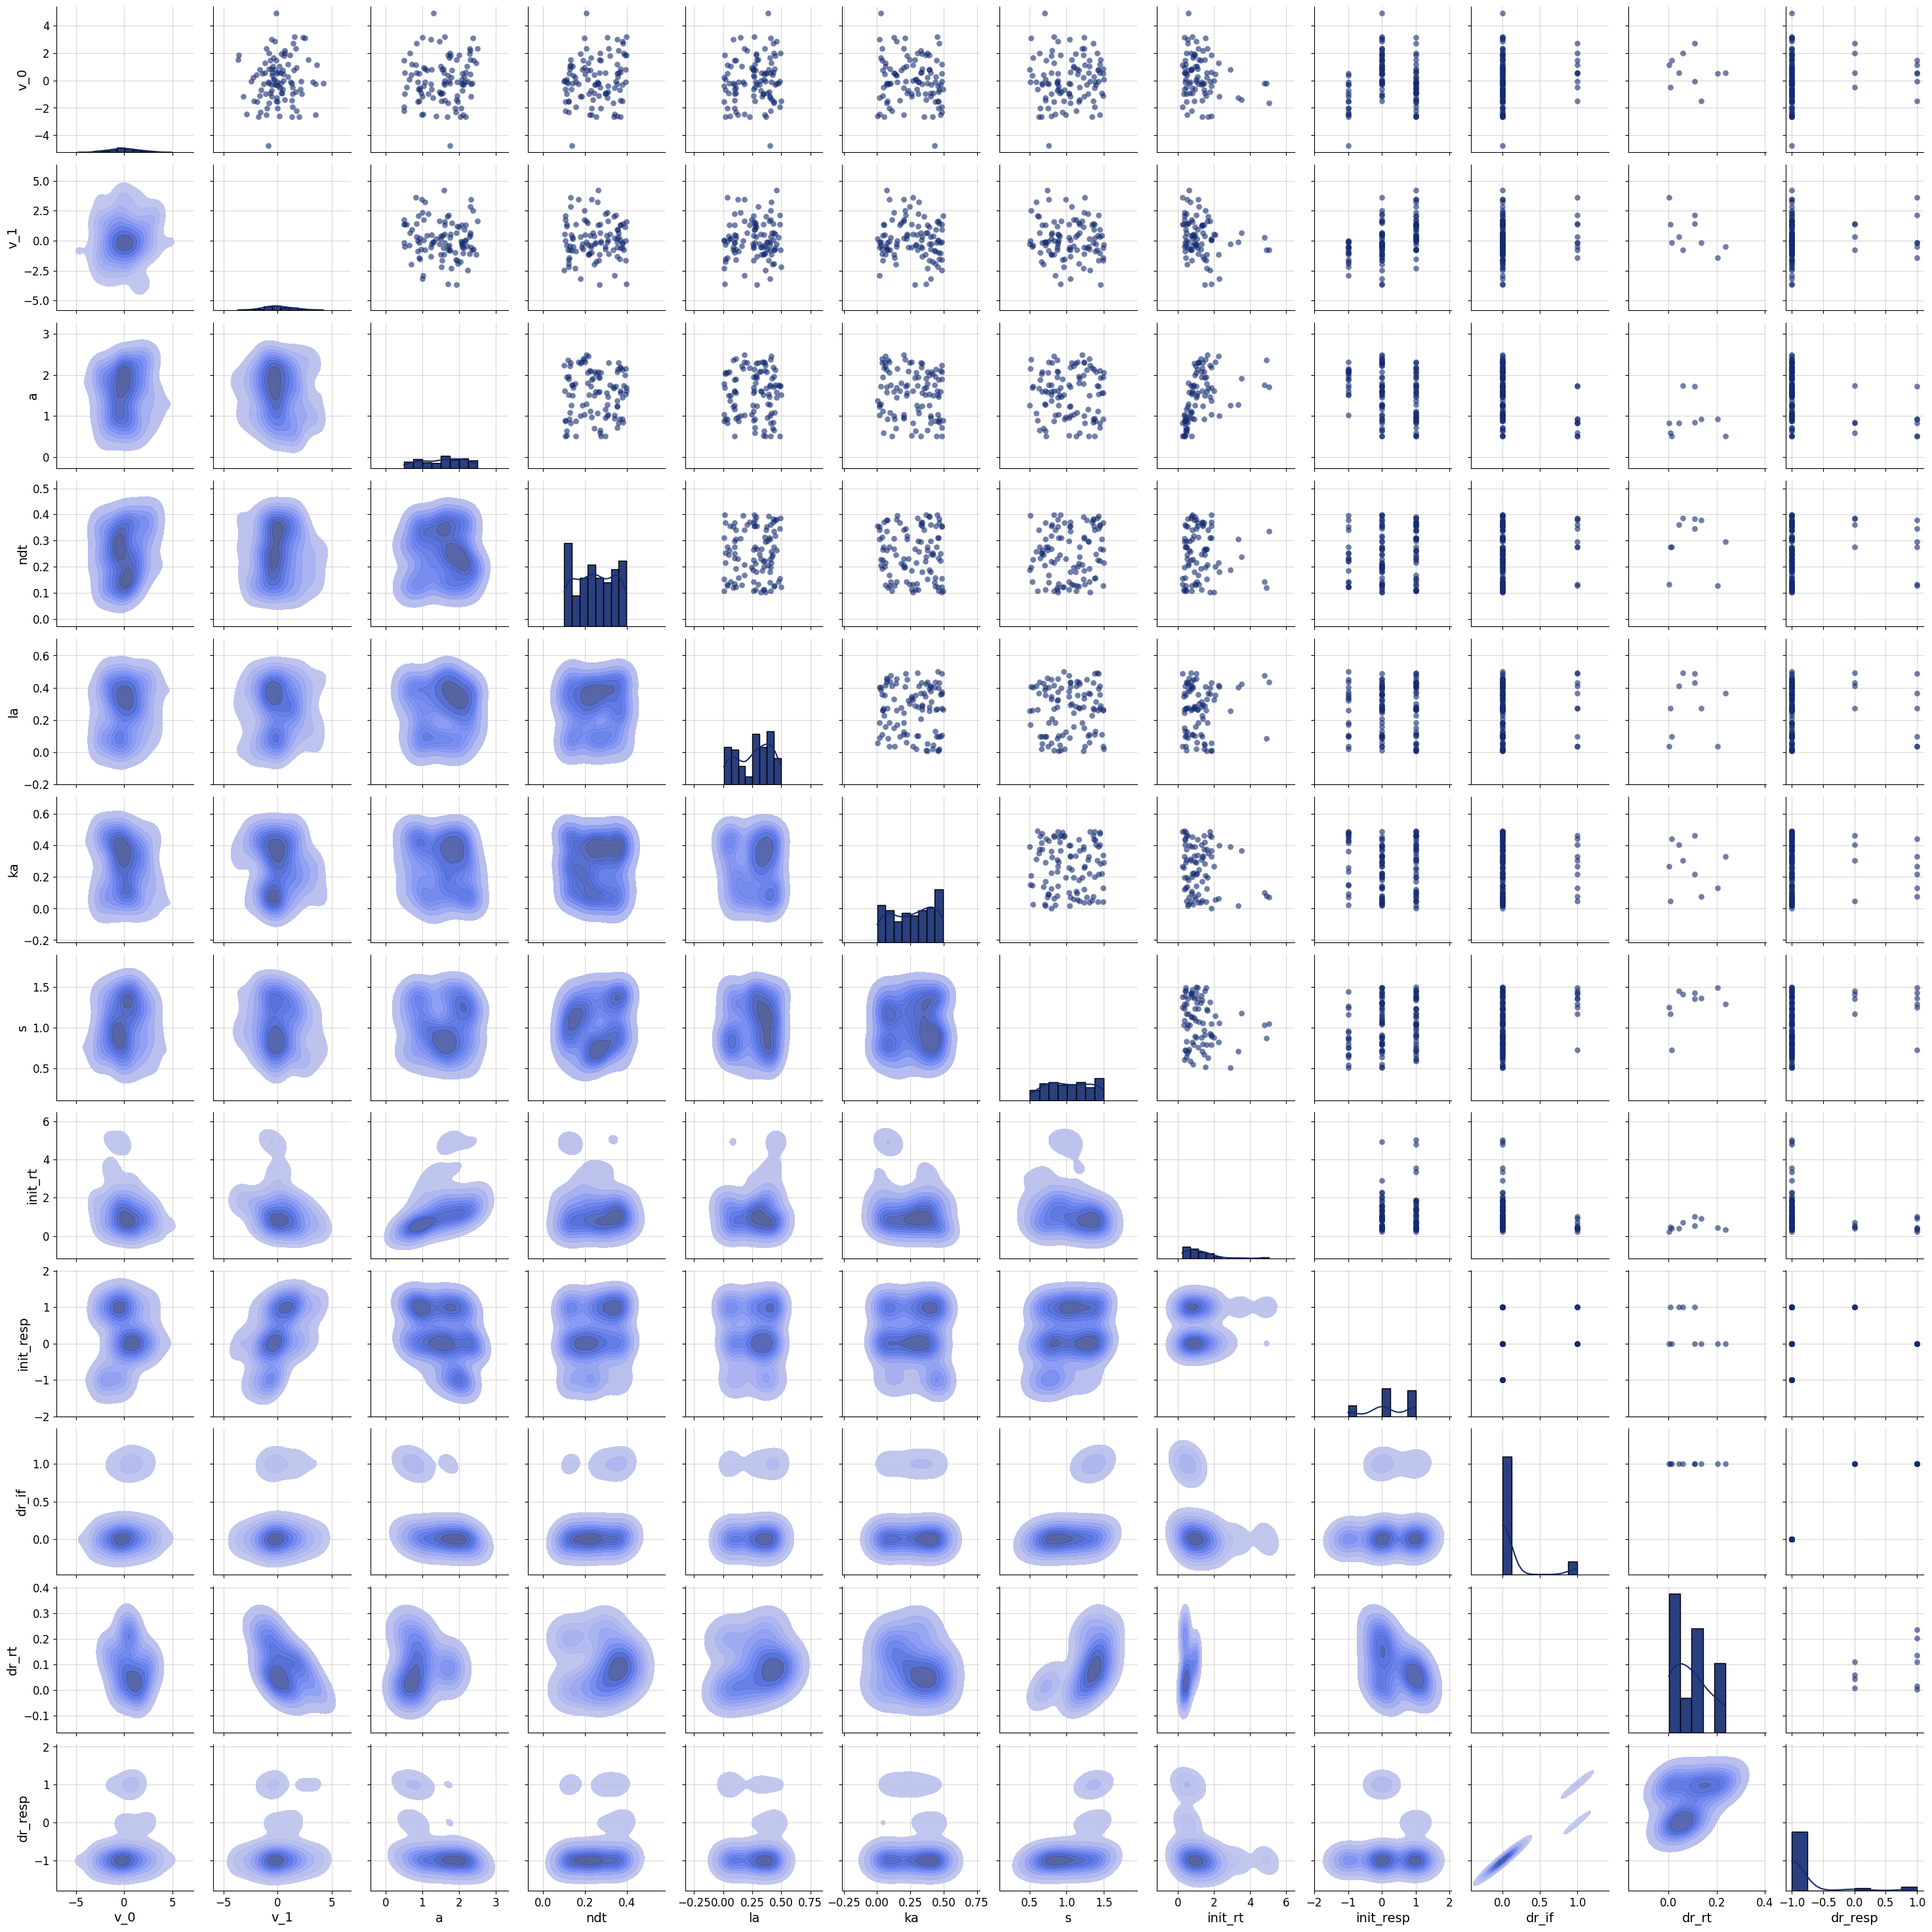

In [ ]:
f = bf.diagnostics.plots.pairs_samples(
    samples=samples
)

In [ ]:
adapter = (
    bf.Adapter()
    .concatenate(["v_0", "v_1", "a", "ndt", "la", "ka", "s"], into="inference_variables")
)

In [ ]:
inference_network = bf.networks.CouplingFlow()

In [ ]:
workflow = bf.BasicWorkflow(
    simulator=simulator,
    adapter=adapter,
    inference_network=inference_network
)

In [ ]:
train_data = simtor.sample(batch_size=1_000)
validation_data = simtor.sample(batch_size=250)

In [ ]:
history = workflow.fit_offline(data=train_data, validation_data=validation_data, epochs=50, batch_size=64, num_batches_per_epoch=50)

INFO:bayesflow:Fitting on dataset instance of OfflineDataset.
INFO:bayesflow:Building on a test batch.


Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 18s 81ms/step - loss: 9.9739 - val_loss: 9.9883
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 9.9188 - val_loss: 9.9925
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 9.9310 - val_loss: 9.9938
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 9.9172 - val_loss: 9.9976
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 9.9338 - val_loss: 10.0014
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 9.9272 - val_loss: 10.0018
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 9.9253 - val_loss: 10.0046
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 9.9162 - val_loss: 10.0050
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 9.9233 - val_loss: 10.0032
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 9.9237 - val_loss: 9.9963
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 9.9187 - val_loss: 10.0041
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - lo

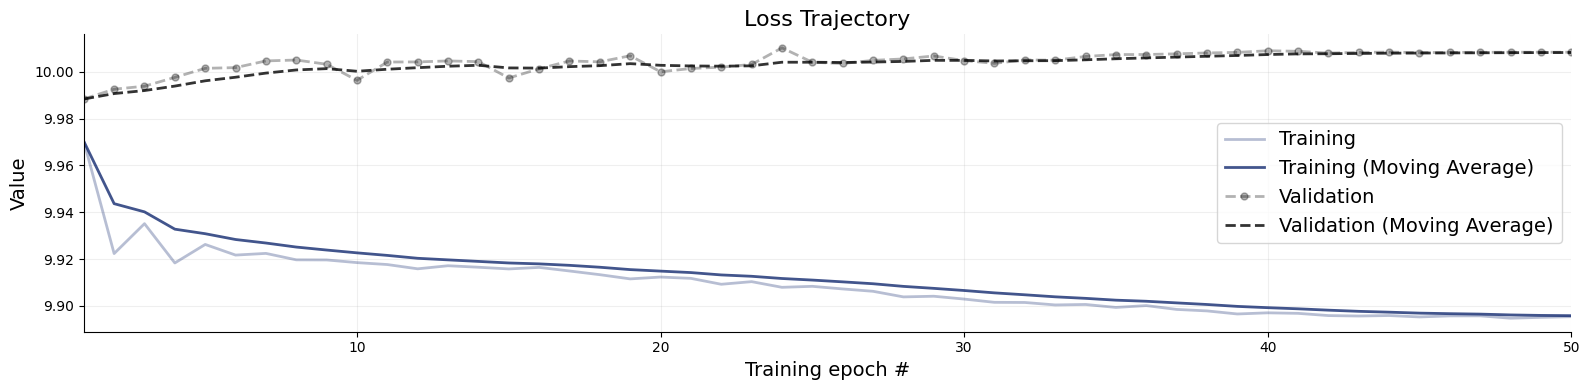

In [ ]:
f = bf.diagnostics.plots.loss(history)

In [ ]:
# Load the data from the text file
# We assume the data is space-separated and has a header row
# You might need to adjust the separator and header based on the actual file format
try:
    practice_data = pd.read_csv('practice_data.txt', sep=' ')
    print("Data loaded successfully:")
    print(practice_data.head())
except FileNotFoundError:
    print("Error: practice_data.txt not found. Please upload the file.")
    # You might want to upload the file here using files.upload() if it's not present
except Exception as e:
    print(f"An error occurred while reading the file: {e}")

Data loaded successfully:
  subj  block  trialnr    stim  wnw         freq  resp     RT  correct
0   S1      1        1  schork    2            0     1  663.8        0
1   S1      1        2  smeris    1  5,341176471     1  564.7        1
2   S1      1        3  jargon    1  4,094117647     1  684.2        1
3   S1      1        4   getij    1  3,976470588     1  642.7        1
4   S1      1        5  zindig    2            0     2  866.3        1


In [ ]:
# prompt: test the model with the dataset we imported

import numpy as np
# Prepare the observed data for inference
# Assuming 'practice_data' DataFrame is loaded and ready

# Extract relevant columns from your dataframe.
# You need 'initial response time', 'initial choice', 'double response indicator',
# 'double response time relative', 'double response choice'.
# Replace the column names below with the actual column names in your 'practice_data'
# Ensure your initial choices and double choices are 0-indexed (e.g., 0 or 1)
# If they are 1-indexed (e.g., 1 or 2), subtract 1.
observed_data = {
    'init_rt': np.array(practice_data['rt'].values, dtype=np.float32),
    'init_resp': np.array(practice_data['choice'].values - 1, dtype=np.int32), # Assuming choice is 1-indexed
    'dr_if': np.array(practice_data['dr_indicator'].values, dtype=np.int32),
    'dr_rt': np.array(practice_data['dr_rt_relative'].values, dtype=np.float32),
    'dr_resp': np.array(practice_data['dr_choice'].values - 1, dtype=np.int32), # Assuming dr_choice is 1-indexed
}

# Run amortized inference
# Generate posterior samples given the observed data
num_posterior_samples = 1000
posterior_samples = workflow.posterior(observed_data, n_samples=num_posterior_samples)

print("\nPosterior samples generated:")
print(posterior_samples.keys())

# You can now analyze the posterior samples, e.g., compute summary statistics or plot marginals
# For example, print the mean of the posterior distributions
print("\nPosterior means:")
for param, values in posterior_samples.items():
    print(f"{param}: {np.mean(values):.4f}")

# Plotting marginal posteriors (requires matplotlib)
import matplotlib.pyplot as plt
f = bf.diagnostics.plots.pairs_posterior(
    samples=posterior_samples,
    # Specify parameter names if you want a specific order or subset
    param_names=["v_0", "v_1", "a", "ndt", "la", "ka", "s"]
)
plt.suptitle("Marginal Posterior Distributions for LCA Parameters")
plt.tight_layout()
plt.show()

# Further analysis might involve:
# - Checking convergence diagnostics
# - Comparing posteriors to priors
# - Performing posterior predictive checks (simulating data from the model with posterior samples and comparing to observed data)

# Example of simulating from the posterior predictive distribution (optional)
# print("\nRunning posterior predictive check...")
# num_predictive_samples = 100 # Number of parameter sets drawn from posterior
# num_trials_per_set = 100    # Number of trials simulated per parameter set
# predictive_data = workflow.posterior_predictive(
#     observed_data,
#     n_post_samples=num_predictive_samples,
#     n_sim_per_post_sample=num_trials_per_set
# )

# print("\nPredictive data generated:")
# print(predictive_data.keys())

# You can then analyze 'predictive_data' (e.g., distributions of RTs, choices, double response rates)
# and compare them to the 'observed_data' to assess the model's fit.


In [ ]:
# Assuming the loaded dataframe `practice_data` has columns that correspond
# to the observable data expected by your model.
# You will need to identify which columns represent the initial RT,
# initial response, double response indicator, relative double RT, and double response.
# Let's assume the relevant columns are named 'rt', 'resp', 'dr_if', 'dr_rt', 'dr_resp'
# You will need to replace these with the actual column names from your file.

# Prepare the data for inference
# The structure should match what the adapter expects for observation data.
# The adapter concatenates parameters into 'inference_variables'.
# The observation data structure needs to align with how the simulator provides
# observational outputs, which is a dictionary with keys like 'init_rt', 'init_resp', etc.

# Create a dictionary where keys are the names of the observable variables
# and values are arrays from the loaded data.
# Make sure the column names here match your data file and the simulator output keys.
try:
    observed_data = {
        'init_rt': practice_data['RT'].values,      # Replace 'rt' with your RT column name
        'init_resp': practice_data['resp'].values,  # Replace 'resp' with your initial response column name
   }

    # Run inference using the trained workflow
    # The `infer` method takes the observed data and the number of posterior samples to draw.
    # The adapter handles mapping the observations to the inference network input.
    num_posterior_samples = 1000 # Number of samples to draw from the posterior
    print(f"\nRunning inference on the loaded data with {num_posterior_samples} samples...")

    # The adapter needs to be applied to the observed data structure
    # The workflow's `infer` method expects the pre-processed observations
    # The adapter needs to be used explicitly to transform the dictionary structure

    # The `infer` method of BasicWorkflow directly takes the observed data dictionary
    # provided it matches the simulator's output structure.
    posterior_samples = workflow.infer(observed_data, n_post_samples=num_posterior_samples)

    print("\nInference complete. Posterior samples obtained.")
    print("Shape of posterior samples:", posterior_samples.shape)
    # The shape should be (num_posterior_samples, num_parameters_after_concatenation)
    # In this case: (num_posterior_samples, 7) because 'inference_variables' contains 7 parameters.

    # You can now analyze the `posterior_samples`.
    # For example, view the first few samples:
    # print(posterior_samples[:5])

    # Or plot the posterior distributions (requires identifying the parameters again)
    # You'd need to reverse the adapter or access the concatenated parameters correctly.
    # For example, if you know the order:
    # posterior_df = pd.DataFrame(posterior_samples, columns=['v_0', 'v_1', 'a', 'ndt', 'la', 'ka', 's'])
    # f_posterior = bf.diagnostics.plots.pairs_samples(samples={'posterior': posterior_df.values})

except KeyError as e:
    print(f"Error: Column not found in the data file: {e}. Please check your column names.")
except NameError:
    print("Error: Workflow or simulator object not defined. Please ensure previous code ran successfully.")



Running inference on the loaded data with 1000 samples...


AttributeError: 'BasicWorkflow' object has no attribute 'infer'